# tf.keras模型构建

TensorFlow 2.0全面keras化：如果你想使用高级的layers，只能选择keras。

TensorFlow 1.x存在tf.layers以及tf.contrib.slim等高级API来创建模型，但是2.0仅仅支持tf.keras.layers，不管怎么样，省的大家重复造轮子，也意味着模型构建的部分大家都是统一的，增加代码的复用性（回忆一下原来的TensorFlow模型构建真是千奇百怪）。

值得注意的tf.nn模块依然存在，里面是各种常用的nn算子，不过大部分人不会去直接用这些算子构建模型，因为keras.layers基本上包含了常用的网络层。

- [1. 采用Keras原有方式](#1.采用Keras原有方式)

  - [1.1 tf.keras.layers中网络配置](#1.1tf.keras.layers中网络配置)
  

- [2. 采用keras的functional API](#2.采用keras的functional_API)

  - [2.1 查看模型结构的两种方法](#2.1查看模型结构的两种方法)
  
  - [2.2 使用共享网络创建多个模型](#2.2使用共享网络创建多个模型)
  
  - [2.3 多输入与多输出网络](#2.3多输入与多输出网络)
  
  - [2.4 小型残差网络](#2.4小型残差网络)
  
  - [2.5 共享网络层](#2.5共享网络层)
  
  - [2.6 模型复用 tensorflow.keras.applications](#2.6模型复用)


- [3. 自定义layer&model](#3.自定义layer和model)

  - [3.1 自定义layer](#3.1自定义layer)
  
  - [3.2 自定义model](#3.2自定义model)
  

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
tf.keras.backend.clear_session()   # For easy reset of notebook state.

# 1.采用Keras原有方式

In [2]:
model = tf.keras.Sequential()
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


# 或者
model = tf.keras.Sequential([
layers.Dense(64, activation='relu', input_shape=(32,)),
layers.Dense(64, activation='relu'),
layers.Dense(10, activation='softmax')])

model = tf.keras.models.Sequential([ 
    tf.keras.layers.Flatten(input_shape=(28, 28)), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(10, activation='softmax')]) 

In [3]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## 1.1tf.keras.layers中网络配置

`activation`：设置层的激活函数。此参数由内置函数的名称指定，或指定为可调用对象。默认情况下，系统不会应用任何激活函数。

`kernel_initializer` 和 `bias_initializer`：创建层权重（核和偏差）的初始化方案。此参数是一个名称或可调用对象，默认为 "Glorot uniform" 初始化器。

`kernel_regularizer` 和 `bias_regularizer`：应用层权重（核和偏差）的正则化方案，例如 L1 或 L2 正则化。默认情况下，系统不会应用正则化函数。

In [5]:
layers.Dense(32, activation='sigmoid')
layers.Dense(32, activation=tf.sigmoid)
layers.Dense(32, kernel_initializer='orthogonal')
layers.Dense(32, kernel_initializer=tf.keras.initializers.glorot_normal)
layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.01))
layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l1(0.01))

# 2.采用keras的functional_API

功能API是一种创建模型的方式，该方法比Sequential方法更加灵活：

**它可以处理具有非线性拓扑的模型，具有共享层的模型以及具有多个输入或输出的模型。**

它基于这样的思想，即深度学习模型通常是层的有向无环图（DAG）。Functional API一组用于构建层图的工具。

In [4]:
inputs = keras.Input(shape=(784,), name='img')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

## 2.1查看模型结构的两种方法

- model.summary()
- keras.utils.plot_model(model, 'model_info.png', show_shapes=True)

[回到目录](#tf.keras模型构建)

In [5]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


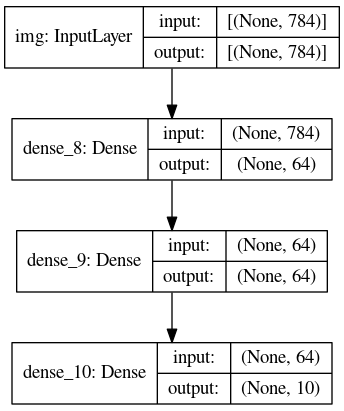

In [8]:
# !pip3 install pydot
#!yum -y install graphviz

keras.utils.plot_model(model, 'model_info.png', show_shapes=True)

## 2.2使用共享网络创建多个模型
- 通过在图层图中指定其输入和输出来创建模型。 这意味着可以使用单个图层图来生成多个模型。
- 可以模型拼接，当作一层网络使用

[回到目录](#tf.keras模型构建)

In [12]:
# 编码器网络和自编码器网络
encode_input = keras.Input(shape=(28,28,1), name='img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)     # Param (16*3*3+1)*32
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

h2 = layers.Reshape((4, 4, 1))(encode_output)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)

autoencoder = keras.Model(inputs=encode_input, outputs=decode_output, name='autoencoder')

autoencoder.summary()
# keras.utils.plot_model(autoencoder, 'autoencoder_info.png', show_shapes=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 16)                0   

In [13]:
# 图层进行拼接

encode_input = keras.Input(shape=(28,28,1), name='src_img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
# encode_model.summary()

decode_input = keras.Input(shape=(16,), name='encoded_img')
h2 = layers.Reshape((4, 4, 1))(decode_input)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)
decode_model = keras.Model(inputs=decode_input, outputs=decode_output, name='decoder')
# decode_model.summary()

autoencoder_input = keras.Input(shape=(28,28,1), name='img')
h3 = encode_model(autoencoder_input)
autoencoder_output = decode_model(h3)
autoencoder = keras.Model(inputs=autoencoder_input, outputs=autoencoder_output,
                          name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                18672     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


## 2.3多输入与多输出网络

[回到目录](#tf.keras模型构建)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     128000      title[0][0]                      
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     128000      body[0][0]                       
______________________________________________________________________________________________

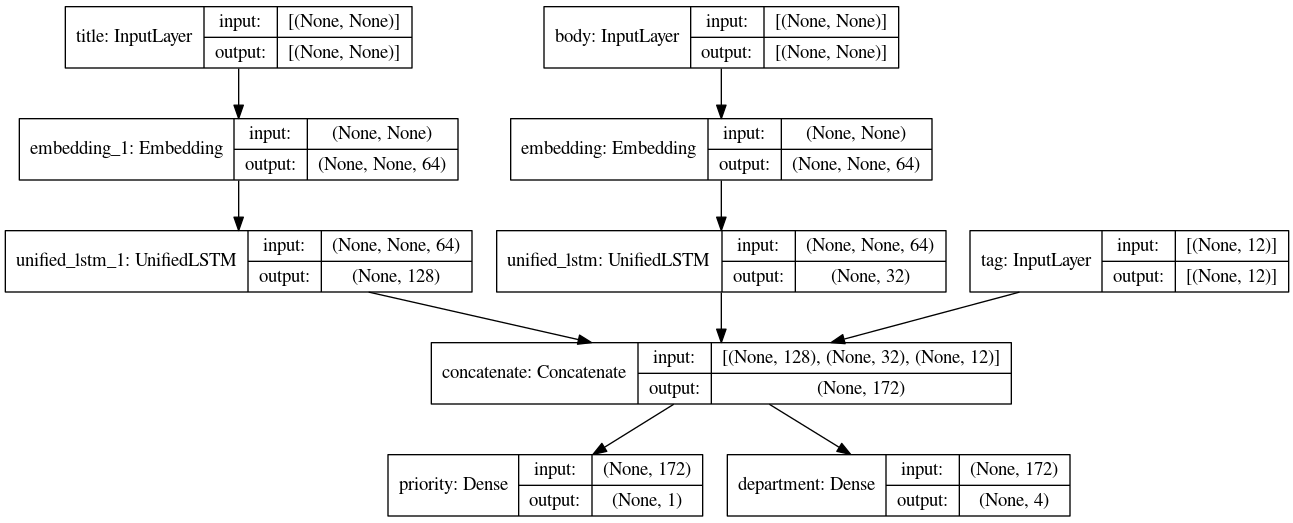

In [14]:
# 构建一个根据文档内容、标签和标题，预测文档优先级和执行部门的网络
# 超参
num_words = 2000
num_tags = 12
num_departments = 4

# 输入
body_input = keras.Input(shape=(None,), name='body')
title_input = keras.Input(shape=(None,), name='title')
tag_input = keras.Input(shape=(num_tags,), name='tag')

# 嵌入层
body_feat = layers.Embedding(num_words, 64)(body_input)
title_feat = layers.Embedding(num_words, 64)(title_input)

# 特征提取层
body_feat = layers.LSTM(32)(body_feat)         #Param : 4（nm+nn+n）其中 n为32，m为64
title_feat = layers.LSTM(128)(title_feat)
features = layers.concatenate([title_feat,body_feat, tag_input])

# 分类层
priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(features)
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(features)

# 构建模型
model = keras.Model(inputs=[body_input, title_input, tag_input],
                    outputs=[priority_pred, department_pred])
model.summary()
keras.utils.plot_model(model, 'multi_model.png', show_shapes=True)

In [17]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss={'priority': 'binary_crossentropy',
                  'department': 'categorical_crossentropy'},
             loss_weights=[1., 0.2])

import numpy as np
# 载入输入数据
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tag_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')
# 标签
priority_label = np.random.random(size=(1280, 1))
department_label = np.random.randint(2, size=(1280, num_departments))
# 训练
history = model.fit(
    {'title': title_data, 'body':body_data, 'tag':tag_data},
    {'priority':priority_label, 'department':department_label},
    batch_size=32,
    epochs=5
)

Epoch 1/5
1280/1280 [==============================] - 18s 14ms/sample - loss: 1.2515 - priority_loss: 0.6982 - department_loss: 2.7664
Epoch 2/5
1280/1280 [==============================] - 17s 14ms/sample - loss: 1.2244 - priority_loss: 0.6799 - department_loss: 2.7227
Epoch 3/5
1280/1280 [==============================] - 17s 13ms/sample - loss: 1.1395 - priority_loss: 0.6084 - department_loss: 2.6553
Epoch 4/5
1280/1280 [==============================] - 17s 13ms/sample - loss: 1.0780 - priority_loss: 0.5599 - department_loss: 2.5903
Epoch 5/5
1280/1280 [==============================] - 17s 14ms/sample - loss: 1.0407 - priority_loss: 0.5370 - department_loss: 2.5184


## 2.4小型残差网络

[回到目录](#tf.keras模型构建)

Model: "small resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_21[0][0]                  
_______________________________________________________________________________________

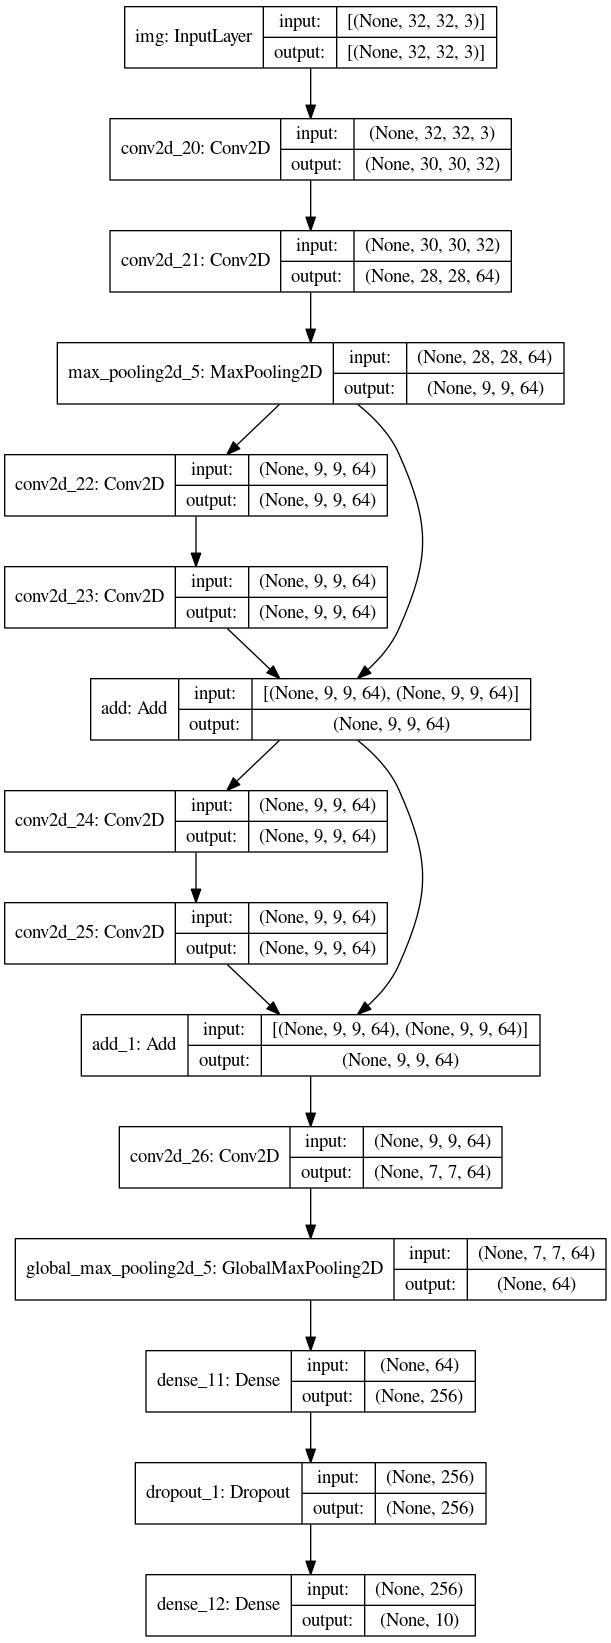

In [18]:
inputs = keras.Input(shape=(32,32,3), name='img')
h1 = layers.Conv2D(32, 3, activation='relu')(inputs)
h1 = layers.Conv2D(64, 3, activation='relu')(h1)
block1_out = layers.MaxPooling2D(3)(h1)

h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(block1_out)
h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(h2)
block2_out = layers.add([h2, block1_out])

h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(block2_out)
h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(h3)
block3_out = layers.add([h3, block2_out])

h4 = layers.Conv2D(64, 3, activation='relu')(block3_out)
h4 = layers.GlobalMaxPool2D()(h4)
h4 = layers.Dense(256, activation='relu')(h4)
h4 = layers.Dropout(0.5)(h4)
outputs = layers.Dense(10, activation='softmax')(h4)

model = keras.Model(inputs, outputs, name='small resnet')
model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)

In [19]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = y_train.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss='categorical_crossentropy',
             metrics=['acc'])
model.fit(x_train, y_train,
         batch_size=64,
         epochs=1,
         validation_split=0.2)

#model.predict(x_test, batch_size=32)

170500096/170498071 [==============================] - 109s 1us/step
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 134s 3ms/sample - loss: 1.8426 - acc: 0.3122 - val_loss: 1.6133 - val_acc: 0.4109


## 2.5共享网络层
```python
share_embedding = layers.Embedding(1000, 64)

input1 = keras.Input(shape=(None,), dtype='int32')
input2 = keras.Input(shape=(None,), dtype='int32')

feat1 = share_embedding(input1)
feat2 = share_embedding(input2)
```

## 2.6模型复用
```python
from tensorflow.keras.applications import VGG16
vgg16=VGG16()

feature_list = [layer.output for layer in vgg16.layers]
feat_ext_model = keras.Model(inputs=vgg16.input, outputs=feature_list)

img = np.random.random((1, 224, 224, 3).astype('float32'))
ext_features = feat_ext_model(img)
```

可以做分类，可以用来提取图片特征，也可以得到任意一层的处理结果

详细使用可见https://github.com/fchollet/deep-learning-models



[回到目录](#tf.keras模型构建)

# 3.自定义layer和model

https://www.tensorflow.org/guide/keras/custom_layers_and_models

**无自定义时的流程介绍**

In [3]:
inputs = tf.keras.Input(shape=(784,), name='img')
h1 = layers.Dense(32, activation='relu')(inputs)
h2 = layers.Dense(32, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist model')

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_scores[0])
print('test acc:', test_scores[1])

model.save('model_save.h5')
del model
model = keras.models.load_model('model_save.h5')

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 40us/sample - loss: 0.4299 - accuracy: 0.8789 - val_loss: 0.2311 - val_accuracy: 0.9322
Epoch 2/5
48000/48000 [==============================] - 2s 35us/sample - loss: 0.2112 - accuracy: 0.9382 - val_loss: 0.1843 - val_accuracy: 0.9473
Epoch 3/5
48000/48000 [==============================] - 2s 34us/sample - loss: 0.1656 - accuracy: 0.9506 - val_loss: 0.1608 - val_accuracy: 0.9552
Epoch 4/5
48000/48000 [==============================] - 2s 33us/sample - loss: 0.1399 - accuracy: 0.9588 - val_loss: 0.1566 - val_accuracy: 0.9546
Epoch 5/5
48000/48000 [==============================] - 2s 33us/sample - loss: 0.1227 - accuracy: 0.9638 - val_loss: 0.1372 - val_accuracy: 0.9604
test loss: 0.13225298466198146
test acc: 0.961


**有自定义时的流程介绍**

- 想构建新的layer，可以直接继承 `tf.keras.layers.Layer`
- 可以继承 `Model类`，创建包含 `多layers` 的模块或者模型
- 更进一步地，我们可以在复用上一步的 `block` 就像使用 `tf.keras.layers` 一样构建更复杂的模块

# 3.1自定义layer

定义网络层就是：设置 **网络权重** 和 **输出到输入的计算过程**

- [3.1.1 自定义网络层](#3.1.1自定义网络层)
- [3.1.2 了解Layer本身](#3.1.2了解Layer本身)
- [3.1.3 使用子层递归构建网络层](#3.1.3使用子层递归构建网络层)
- [3.1.4 在自定义网络层调用其他网络层](#3.1.4在自定义网络层调用其他网络层)
- [3.1.5 配置只有训练时可以执行的网络层](#3.1.5配置只有训练时可以执行的网络层)
- [3.1.6 使自己的网络层可以序列化](#3.1.6使自己的网络层可以序列化)
- [3.1.7 构建model](#3.1.7构建model)
- [3.1.8 总结](#3.1.8总结)


[回到目录](#tf.keras模型构建)

### 3.1.1 自定义网络层

In [7]:
class MyLayer(layers.Layer):
    def __init__(self, input_dim=32, unit=32):
        super(MyLayer, self).__init__()
        
        w_init = tf.random_normal_initializer()
        self.weight = tf.Variable(initial_value=w_init(shape=(input_dim, unit), dtype=tf.float32), trainable=True)
        
        b_init = tf.zeros_initializer()
        self.bias = tf.Variable(initial_value=b_init(shape=(unit,), dtype=tf.float32), trainable=True)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.weight) + self.bias
        
x = tf.ones((3,5))
my_layer = MyLayer(5, 4)
out = my_layer(x)
print(out)

tf.Tensor(
[[ 0.0197119  -0.21411231  0.12813798 -0.00229884]
 [ 0.0197119  -0.21411231  0.12813798 -0.00229884]
 [ 0.0197119  -0.21411231  0.12813798 -0.00229884]], shape=(3, 4), dtype=float32)


In [13]:
"""
根据上述例子，提出以下几点：
1.按上面构建网络层，图层会自动跟踪权重w和b，当然我们也可以直接用add_weight的方法构建权重
2.也可以设置不可训练的权重
3.★★★网络维度事先不知，则重写build函数
4.★★★可以对call方法应用tf.function，这样模型执行就使用Graph模式了。
"""
print("*********** first ****************")
class MyLayer(layers.Layer):
    def __init__(self, input_dim=32, unit=32):
        super(MyLayer, self).__init__()
        
        self.weight = self.add_weight(shape=(input_dim, unit),
                                     initializer=keras.initializers.RandomNormal(),
                                     trainable=True)
        self.bias = self.add_weight(shape=(unit,),
                                   initializer=keras.initializers.Zeros(),
                                   trainable=True)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.weight) + self.bias
        
x = tf.ones((3,5))
my_layer = MyLayer(5, 4)
out = my_layer(x)
print(out)               # shape [3,4]

print("*********** second ****************")

class AddLayer(layers.Layer):
    def __init__(self, input_dim=32):
        super(AddLayer, self).__init__()
        self.sum = self.add_weight(shape=(input_dim,),
                                     initializer=keras.initializers.Zeros(),
                                     trainable=False)
       
    
    def call(self, inputs):
        self.sum.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.sum
        
x = tf.ones((5,3))
my_layer = AddLayer(3)
out = my_layer(x)
print(out.numpy())       # [5. 5. 5.]
out = my_layer(x)
print(out.numpy())      # [10. 10. 10.]
print('weight:', my_layer.weights)
print('non-trainable weight:', my_layer.non_trainable_weights)
print('trainable weight:', my_layer.trainable_weights)

print("*********** third ****************")

class MyLayer(layers.Layer):
    def __init__(self, unit=32):
        super(MyLayer, self).__init__()
        self.unit = unit
        
    def build(self, input_shape):
        self.weight = self.add_weight(shape=(input_shape[-1], self.unit),
                                     initializer=keras.initializers.RandomNormal(),
                                     trainable=True)
        self.bias = self.add_weight(shape=(self.unit,),
                                   initializer=keras.initializers.Zeros(),
                                   trainable=True)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.weight) + self.bias
        
# 这边的5就可以自动获取
my_layer = MyLayer(3)
x = tf.ones((2,5))
out = my_layer(x)
print(out)   # shape=(2, 3)

*********** first ****************
tf.Tensor(
[[ 0.18118253  0.07326472 -0.07492816 -0.07186516]
 [ 0.18118253  0.07326472 -0.07492816 -0.07186516]
 [ 0.18118253  0.07326472 -0.07492816 -0.07186516]], shape=(3, 4), dtype=float32)
*********** second ****************
[5. 5. 5.]
[10. 10. 10.]
weight: [<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([10., 10., 10.], dtype=float32)>]
non-trainable weight: [<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([10., 10., 10.], dtype=float32)>]
trainable weight: []
*********** third ****************
tf.Tensor(
[[-0.2519603   0.00282956  0.08443176]
 [-0.2519603   0.00282956  0.08443176]], shape=(2, 3), dtype=float32)


### 3.1.2了解Layer本身

Layer本身有很多属性和方法，这里列出一些重要的：

- add_weight方法：用于创建layer的weights（不用直接调用tf.Variale）；

- add_loss方法：顾名思义，用于添加loss，增加的loss可以通过layer.losses属性获得，你可以在call方法中使用该方法添加你想要的loss；

- add_metric方法：添加metric到layer；

- losses属性：通过add_loss方法添加loss的list集合，比如一部分layer的正则化loss可以通过这个属性获得；

- trainable_weights属性：可训练的Variables列表，在模型训练时需要这个属性；

- non_trainable_weights属性：不可训练的Variables列表；

- weights属性：trainable_weights和non_trainable_weights的合集；

- trainable属性：可变动的bool值，决定layer是否可以训练。

### 3.1.3使用子层递归构建网络层

In [14]:
class MyBlock(layers.Layer):
    def __init__(self):
        super(MyBlock, self).__init__()
        self.layer1 = MyLayer(32)
        self.layer2 = MyLayer(16)
        self.layer3 = MyLayer(2)
    def call(self, inputs):
        h1 = self.layer1(inputs)
        h1 = tf.nn.relu(h1)
        h2 = self.layer2(h1)
        h2 = tf.nn.relu(h2)
        return self.layer3(h2)
    
my_block = MyBlock()
print('trainable weights:', len(my_block.trainable_weights))
y = my_block(tf.ones(shape=(3, 64)))
# ★★★构建网络在build()里面，所以执行了才有网络
print('trainable weights:', len(my_block.trainable_weights)) 

trainable weights: 0
trainable weights: 6


### 3.1.4在自定义网络层调用其他网络层

In [26]:
# 超参
time_step = 10
batch_size = 32
hidden_dim = 32
inputs_dim = 5

# 网络
class MyRnn(layers.Layer):
    def __init__(self):
        super(MyRnn, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection1 = layers.Dense(units=hidden_dim, activation='relu')
        self.projection2 = layers.Dense(units=hidden_dim, activation='relu')
        self.classifier = layers.Dense(1, activation='sigmoid')
    def call(self, inputs):
        outs = []
        states = tf.zeros(shape=[inputs.shape[0], self.hidden_dim])
        for t in range(inputs.shape[1]):
            x = inputs[:,t,:]
            h = self.projection1(x)
            y = h + self.projection2(states)
            states = y
            outs.append(y)
        # print(outs)
        features = tf.stack(outs, axis=1)
        print(features.shape)
        return self.classifier(features)

# 构建网络
inputs = keras.Input(batch_shape=(batch_size, time_step, inputs_dim))
x = layers.Conv1D(32, 3)(inputs)
print(x.shape)
outputs = MyRnn()(x)
model = keras.Model(inputs, outputs)

rnn_model = MyRnn()
_ = rnn_model(tf.zeros((1, 10, 5)))

(32, 8, 32)
(32, 8, 32)
(1, 10, 32)


### 3.1.5配置只有训练时可以执行的网络层

```python
class MyDropout(layers.Layer):
    def __init__(self, rate, **kwargs):
        super(MyDropout, self).__init__(**kwargs)
        self.rate = rate
    def call(self, inputs, training=None):
        return tf.cond(training, 
                       lambda: tf.nn.dropout(inputs, rate=self.rate),
                      lambda: inputs)
```

### 3.1.6使自己的网络层可以序列化

In [25]:
class Linear(layers.Layer):

    def __init__(self, units=32, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self):
        config = super(Linear, self).get_config()
        config.update({'units':self.units})
        # return {'units': self.units}
        return config
    
    
layer = Linear(125)
config = layer.get_config()
print(config)
new_layer = Linear.from_config(config)

print("*******************************************")

inputs = keras.Input((4,))
outputs = Linear(10)(inputs)
model = keras.Model(inputs, outputs)
print(model.summary())
config = model.get_config()
print(config)
new_model = keras.Model.from_config(config, custom_objects={'Linear':Linear})
print(new_model.get_config())

{'name': 'linear_14', 'trainable': True, 'dtype': None, 'units': 125}
*******************************************
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
linear_15 (Linear)           (None, 10)                50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'model_8', 'layers': [{'name': 'input_9', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 4), 'dtype': 'float32', 'sparse': False, 'name': 'input_9'}, 'inbound_nodes': []}, {'name': 'linear_15', 'class_name': 'Linear', 'config': {'name': 'linear_15', 'trainable': True, 'dtype': 'float32', 'units': 10}, 'inbound_nodes': [['input_9', 0, 0, {}]]}], 'input_layers': ['input_9', 0,

### 3.1.7构建model

In [16]:
class MyLayer(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[1], self.output_dim))
        self.kernel = self.add_weight(name='kernel1', shape=shape,
                                   initializer='uniform', trainable=True)
        super(MyLayer, self).build(input_shape)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)

    def compute_output_shape(self, input_shape):
        shape = tf.TensorShape(input_shape).as_list()
        shape[-1] = self.output_dim
        return tf.TensorShape(shape)

    def get_config(self):
        base_config = super(MyLayer, self).get_config()
        base_config['output_dim'] = self.output_dim
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
model = tf.keras.Sequential(
[
    MyLayer(10),
    layers.Activation('softmax')
])

# model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
#              loss=tf.keras.losses.categorical_crossentropy,
#              metrics=['accuracy'])

# model.fit(train_x, train_y, batch_size=16, epochs=5)

### 3.1.8总结
通过对 tf.keras.layers.Layer 进行子类化并实现以下方法来创建自定义层：

- build：创建层的权重。使用 add_weight 方法添加权重。

- call：定义前向传播。

- compute_output_shape：指定在给定输入形状的情况下如何计算层的输出形状。

- 可以通过实现 get_config 方法和 from_config 类方法序列化层。

[回到目录](#tf.keras模型构建)

# 3.2自定义model

Layer类是keras中最基本的类，对其有个全面的认识比较重要，具体可以看源码。

大部分情况下，我们只会复用keras已有的layers，而我们创建模型最常用的是`keras.Model类`，**这个Model类是继承了Layer类**，但是提供了更多的API，如`model.compile()`, `model.fit()`, `model.evaluate()`, `model.predict()`等，熟悉keras的都知道这是用于模型训练，评估和预测的方法。

另外重要的一点，**我们可以继承Model类，创建包含多layers的模块或者模型**

- [3.2.1 模型子类化](#3.2.1模型子类化)
- [3.2.2 模块复用](#3.2.2模块复用)
- [3.2.3 完整构建自定义模型](#3.2.3完整构建自定义模型)


[回到目录](#tf.keras模型构建)

### 3.2.1模型子类化

通过对 tf.keras.Model 进行子类化并定义您自己的前向传播来构建完全可自定义的模型。

在 `__init__` 方法中创建层并将它们设置为类实例的属性。在 `call` 方法中定义前向传播

```python
class MyModel(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__(name='my_model')
        self.num_classes = num_classes
        self.layer1 = layers.Dense(32, activation='relu')
        self.layer2 = layers.Dense(num_classes, activation='softmax')
    def call(self, inputs):
        h1 = self.layer1(inputs)
        out = self.layer2(h1)
        return out
    
    def compute_output_shape(self, input_shape):
        shape = tf.TensorShape(input_shape).as_list()
        shape[-1] = self.num_classes
        return tf.TensorShape(shape)

model = MyModel(num_classes=10)
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
             loss=tf.keras.losses.categorical_crossentropy,
             metrics=['accuracy'])

model.fit(train_x, train_y, batch_size=16, epochs=5)
```

### 3.2.2模块复用

In [27]:
class ConvBlock(tf.keras.Model):
    """Convolutional Block consisting of (conv->bn->relu).
    Arguments:
      num_filters: number of filters passed to a convolutional layer.
      kernel_size: the size of convolution kernel
      weight_decay: weight decay
      dropout_rate: dropout rate.
    """

    def __init__(self, num_filters, kernel_size, weight_decay=1e-4, dropout_rate=0.):
        super(ConvBlock, self).__init__()

        self.conv = tf.keras.layers.Conv2D(num_filters,
                                          kernel_size,
                                          padding="same",
                                          use_bias=False,
                                          kernel_initializer="he_normal",
                                          kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
        self.bn = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)


    def call(self, x, training=True):
        output = self.conv(x)
        output = self.bn(x, training=training)
        output = tf.nn.relu(output)
        output = self.dropout(output, training=training)
        return output

model = ConvBlock(32, 3, 1e-4, 0.5)
x = tf.ones((4, 224, 224, 3))
y = model(x)
print(model.layers)

[<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6bb05b7240>, <tensorflow.python.keras.layers.normalization.BatchNormalizationV2 object at 0x7f6bb05d22e8>, <tensorflow.python.keras.layers.core.Dropout object at 0x7f6bb05d2f98>]


In [28]:
"""
这里我们构建了一个包含Conv2D->BatchNorm->ReLU的block，打印model.layers可以获得其内部包含的所有layers。
更进一步地，我们可以在复用这些block就像使用tf.keras.layers一样构建更复杂的模块
"""
class SimpleCNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.block1 = ConvBlock(16, 3)
        self.block2 = ConvBlock(32, 3)
        self.block3 = ConvBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x, training=True):
        output = self.block1(x, training=training)
        output = self.block2(output, training=training)
        output = self.block3(output, training=training)
        output = self.global_pool(output)
        logits = self.classifier(output)
        return logits

model = SimpleCNN(10)
print(model.layers)
x = tf.ones((4, 32, 32, 3))
y = model(x) # [4, 10]

[<__main__.ConvBlock object at 0x7f6bb0755198>, <__main__.ConvBlock object at 0x7f6bbd381278>, <__main__.ConvBlock object at 0x7f6bbd381d68>, <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f6bbd389898>, <tensorflow.python.keras.layers.core.Dense object at 0x7f6bbd389a20>]


### 3.2.3完整构建自定义模型

通常，我们使用Layer类来定义内部计算块，并使用Model类来定义外部模型 - 即要训练的对象。

Model类与Layer的区别：

- 它公开了内置的训练，评估和预测循环（model.fit(),model.evaluate(),model.predict()）。 
- 它通过model.layers属性公开其内层列表。 
- 它公开了保存和序列化API。

下面通过构建一个变分自编码器（VAE），来介绍如何构建自己的网络。

In [29]:
# 采样网络
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

# 编码器
class Encoder(layers.Layer):
    def __init__(self, latent_dim=32, intermediate_dim=64, name='encoder', **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        h1 = self.dense_proj(inputs)
        z_mean = self.dense_mean(h1)
        z_log_var = self.dense_log_var(h1)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z
        
# 解码器
class Decoder(layers.Layer):
    def __init__(self, original_dim, intermediate_dim=64, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    def call(self, inputs):
        h1 = self.dense_proj(inputs)
        return self.dense_output(h1)
    
# 变分自编码器
class VAE(tf.keras.Model):
    def __init__(self, original_dim, latent_dim=32, intermediate_dim=64, name='encoder', **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
    
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim=original_dim, intermediate_dim=intermediate_dim)
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        kl_loss = -0.5*tf.reduce_sum(z_log_var-tf.square(z_mean)-tf.exp(z_log_var)+1)
        self.add_loss(kl_loss)
        return reconstructed

In [30]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
vae = VAE(784,32,64)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=3, batch_size=64)

Epoch 1/3
60000/60000 [==============================] - 3s 53us/sample - loss: 0.8804
Epoch 2/3
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0692
Epoch 3/3
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0679


In [40]:
"""
自己编写训练方法
"""
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

original_dim = 784
vae = VAE(original_dim, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      loss = mse_loss_fn(x_batch_train, reconstructed)
      loss += sum(vae.losses)  # Add KLD regularization loss
      
    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    
    loss_metric(loss)
    
    if step % 100 == 0:
      print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(265.238, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(7.6853933, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(3.9106903, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(2.6406112, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(2.0025573, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(1.6187861, shape=(), dtype=float32)
step 600: mean loss = tf.Tensor(1.3619022, shape=(), dtype=float32)
step 700: mean loss = tf.Tensor(1.1780695, shape=(), dtype=float32)
step 800: mean loss = tf.Tensor(1.0400715, shape=(), dtype=float32)
step 900: mean loss = tf.Tensor(0.9323196, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(0.89736545, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.8178019, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(0.7521484, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(0.69702023, shape=(), dtype=float32)
step 400: mean los